# Project
## Foundations of Machine Learning

The purpose of this project is to build predictive algorithms that estimate whether a food facility inspection in Chicago will fail at the time of inspection. The data come from the City of Chicago’s official Food Inspections dataset (open data portal). Records include facility characteristics, inspection metadata, location, and free-text violation notes.

The data include:
  
- `inspection_id` : Unique identifier of the inspection event
- `inspection_date` : Calendar date of the inspection (parsed to date)
- `facility_type`: Establishment type (e.g., restaurant, grocery store, school)
- `risk`: City-defined risk level of the facility (Risk 1—High, Risk 2—Medium, Risk 3—Low)
- `inspection_type`: Reason or program for the inspection (e.g., canvass, complaint, license, re-inspection)
- `zip`: Five-digit ZIP code of the facility location
- `city`: City name (mostly chicago; retained to flag anomalies)
- `latitude`: Latitude of the facility
- `longitude`: Longitude of the facility
- `results`: Official outcome string (e.g., pass, pass w/ conditions, fail, out of business)
- `violations`: Free-text list of cited violations, often numbered (“1. … 2. …”)

Engineered variables used in modeling/EDA:

- `viol_count` : Count of numbered violations extracted from violations text
- `risk_ord` : Ordinal encoding of risk (High=3, Medium=2, Low=1)
- `ins_year / ins_month / ins_wday` : Year, month, and weekday derived from inspection_date
- `target_fail` : Binary target where 1 denotes an inspection with results == "fail"

We provide two datasets: training_data.csv for building and tuning models, and testing_data.csv held out for final evaluation. All preprocessing and model selection are fit on the training set (with cross-validation inside it). The test set stays untouched until the end to estimate generalization; if test performance drops relative to training, that signals overfitting.



In [49]:
import re, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option("display.max_columns", 200)

train_path = "training_sample1000.csv"
test_path = "testing_sample1000.csv"
dict_path = "datadictionary.txt"

# Expected columns
Expected_columns = ["inspection_id", "inspection_date", "facility_type", "risk",
"inspection_type", "zip", "city","latitude", "longitude", "results", "violations",
"target_fail", "viol_count"
]

# Bounds for chicago
chicago_bound = {"lat_min": 41.60, "lat_max": 42.10, "lon_min": -87.95, "lon_max": -87.50}

In [50]:
# Loading data and inspection
train_raw = pd.read_csv(train_path)
test_raw = pd.read_csv(test_path)
print(train_raw.shape)
print(test_raw.shape)

display(train_raw.head())
display(test_raw.head())

print("\nTRAIN info():"); train_raw.info()
print("\nTEST info():"); test_raw.info()



(1000, 13)
(1000, 13)


,inspection_id,inspection_date,facility_type,risk,inspection_type,zip,city,latitude,longitude,results,violations,target_fail,viol_count
0,134247,2010-01-07,Restaurant,risk 1 (high),Canvass,60647.0,CHICAGO,41.924474,-87.718667,fail,NaN,1,0
1,2582303,2023-09-26,School,risk 1 (high),Canvass,60609.0,CHICAGO,41.807263,-87.661139,pass,NaN,0,0
2,1950562,2016-08-16,Restaurant,risk 3 (low),Canvass,60610.0,CHICAGO,41.908100,-87.634764,pass,"30. FOOD IN ORIGINAL CONTAINER, PROPERLY LABEL...",0,1
3,1493806,2014-08-19,Restaurant,risk 1 (high),Canvass,60649.0,CHICAGO,41.765671,-87.566653,fail,2. FACILITIES TO MAINTAIN PROPER TEMPERATURE -...,1,17
4,2553721,2022-03-31,Restaurant,risk 1 (high),Short Form Complaint,60614.0,CHICAGO,41.930201,-87.643761,pass,57. ALL FOOD EMPLOYEES HAVE FOOD HANDLER TRAIN...,0,2


,inspection_id,inspection_date,facility_type,risk,inspection_type,zip,city,latitude,longitude,results,violations,target_fail,viol_count
0,1369598,2013-10-10,Restaurant,risk 1 (high),Canvass,60657.0,CHICAGO,41.946827,-87.664156,fail,"16. FOOD PROTECTED DURING STORAGE, PREPARATION...",1,8
1,2500621,2021-04-22,School,risk 1 (high),Canvass Re-Inspection,60612.0,CHICAGO,41.885294,-87.705819,pass,"55. PHYSICAL FACILITIES INSTALLED, MAINTAINED ...",0,1
2,1588856,2015-11-24,Restaurant,risk 1 (high),License Re-Inspection,60607.0,CHICAGO,41.864756,-87.646699,pass,"41. PREMISES MAINTAINED FREE OF LITTER, UNNECE...",0,2
3,2253062,2019-01-24,Restaurant,risk 1 (high),Canvass Re-Inspection,60604.0,CHICAGO,41.878565,-87.627835,pass w/ conditions,5. PROCEDURES FOR RESPONDING TO VOMITING AND D...,0,3
4,2578752,2023-07-18,Children's Services Facility,risk 1 (high),License,60630.0,CHICAGO,41.971031,-87.744680,fail,"48. WAREWASHING FACILITIES: INSTALLED, MAINTAI...",1,1



TRAIN info():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   inspection_id    1000 non-null   int64  
 1   inspection_date  1000 non-null   object 
 2   facility_type    972 non-null    object 
 3   risk             1000 non-null   object 
 4   inspection_type  1000 non-null   object 
 5   zip              1000 non-null   float64
 6   city             1000 non-null   object 
 7   latitude         1000 non-null   float64
 8   longitude        1000 non-null   float64
 9   results          1000 non-null   object 
 10  violations       733 non-null    object 
 11  target_fail      1000 non-null   int64  
 12  viol_count       1000 non-null   int64  
dtypes: float64(3), int64(3), object(7)
memory usage: 101.7+ KB

TEST info():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   

In [51]:
# Schema checks

def assert_schema(df: pd.DataFrame, name: str):
  missing = [c for c in Expected_columns if c not in df.columns]
  assert not missing, f"{name} is missing columns: {missing}"

assert_schema(train_raw, "train_raw")
assert_schema(test_raw, "test_raw")
print("Schema checks passed for train and test")

Schema checks passed for train and test


In [52]:
# Cleaning helper functions

def normalize_city(s: pd.Series) -> pd.Series:
  return s.astype(str).str.strip().str.title()

def normalize_zip(s: pd.Series) -> pd.Series:
  def _fmt(x):
    if pd.isna(x): return np.nan
    try:
      z = int(float(x))
      if z <= 0: return np.nan
      return f"{z:05d}"
    except Exception:
      return np.nan
  return s.apply(_fmt)

def parse_date(s: pd.Series) -> pd.Series:
  return pd.to_datetime(s, errors="coerce")

def normalize_results(s:pd.Series) -> pd.Series:
  x = s.astype(str).str.lower().str.strip().str.replace(r"\s+"," ", regex = True)
  mapping = {
      "pass" : "pass",
      "pass w/ condition" : "pass w/ conditions",
      "pass w/ condition" : "pass w/ condition",
      "pass with conditions": "pass w/ conditions",
      "fail": "fail",
      "out of business" : "out of business",
      "not ready": "not ready",
      "no entry": "no entry",
      "business not located": "business not located",
  }
  return x.map(mapping).fillna(x)


def risk_to_ordinal(s: pd.Series) -> pd.Series:
  s = s.replace({"": pd.NA, "nan": pd.NA, "NaN": pd.NA, "None": pd.NA,
                "none": pd.NA, "NULL": pd.NA, "null": pd.NA})
  x = s.astype(str).str.lower()
  res = pd.Series(pd.NA, index=s.index, dtype = "Int64")

  num = pd.to_numeric(x.str.extract(r'(\d+)', expand = False), errors="coerce")
  res.loc[num == 1] = 3
  res.loc[num == 2] = 2
  res.loc[num == 3] = 1

  res.loc[x.str.contains("high", na = False)] = 3
  res.loc[x.str.contains("medium", na= False)] = 2
  res.loc[x.str.contains("low", na=False)] = 1
  return res

def count_violations(viol_col: pd.Series) -> pd.Series:
  if pd.api.types.is_numeric_dtype(viol_col):
    return viol_col.fillna(0).astype("Int64")
  def _count(v):
    if pd.isna(v): return 0
    txt = str(v)
    if "|" in txt: return len([t for t in txt.split("|") if t.strip()])
    if ";" in txt: return len([t for t in txt.split(";") if t.strip()])
    found = re.findall(r"\d{2,}", txt)
    return max(len(found),1 )
  return viol_col.apply(_count).astype("Int64")


In [53]:
# clean raw data

def clean_inspections(df: pd.DataFrame) -> pd.DataFrame:
  out = df.copy()

  # Drop duplicates
  if "inspection_id" in out.columns:
    out = out.drop_duplicates(subset=["inspection_id"])

  # Normalize text columns
  for c in out.select_dtypes(include=["object"]).columns:
    out[c] = out[c].astype(str).str.strip()

  # City normalization + Chicago flag
  if "city" in out.columns:
    out["city"] = normalize_city(out["city"])
    out["city_is_chicago"] = (out["city"] == "Chicago").astype("Int8")

  # Zip normalization
  if "zip" in out.columns:
    out["zip"] = normalize_zip(out["zip"])

  # Date
  if "inspection_date" in out.columns:
    out["inspection_date"] = parse_date(out["inspection_date"])
    out["ins_year"] = out["inspection_date"].dt.year.astype("Int64")
    out["ins_month"] = out["inspection_date"].dt.month.astype("Int64")
    out["ins_wday"] = out["inspection_date"].dt.weekday.astype("Int64")

  # Results + binary target
  if "results"  in out.columns:
    out["results"] = normalize_results(out["results"])
    out["target_fail"] = out["results"].eq("fail").astype("Int8")
  if "target_fail" in out.columns:
    out["target_fail"] = out["results"].eq("fail").astype("Int8")

  # Risk ordinal
  if "risk" in out.columns:
    out["risk_ord"] = risk_to_ordinal(out["risk"])

  # Violations count
  if "violations" in out.columns:
    out["viol_count"] = count_violations(out["violations"])

  # Lat/Lon sanity bounds
  b = chicago_bound
  if {"latitude", "longitude"}.issubset(out.columns):
      lat_ok = out["latitude"].between(b["lat_min"], b["lat_max"])
      lon_ok = out["longitude"].between(b["lon_min"], b["lon_max"])
      out.loc[~(lat_ok & lon_ok), ["latitude", "longitude"]] = np.nan

  return out

train_clean = clean_inspections(train_raw)
test_clean = clean_inspections(test_raw)

print("train_clean shape: " , train_clean.shape)
print("test_clean shape: " , test_clean.shape)
display(train_clean.head())

train_clean shape:  (1000, 18)
test_clean shape:  (1000, 18)


,inspection_id,inspection_date,facility_type,risk,inspection_type,zip,city,latitude,longitude,results,violations,target_fail,viol_count,city_is_chicago,ins_year,ins_month,ins_wday,risk_ord
0,134247,2010-01-07,Restaurant,risk 1 (high),Canvass,60647,Chicago,41.924474,-87.718667,fail,nan,1,1,1,2010,1,3,3
1,2582303,2023-09-26,School,risk 1 (high),Canvass,60609,Chicago,41.807263,-87.661139,pass,nan,0,1,1,2023,9,1,3
2,1950562,2016-08-16,Restaurant,risk 3 (low),Canvass,60610,Chicago,41.908100,-87.634764,pass,"30. FOOD IN ORIGINAL CONTAINER, PROPERLY LABEL...",0,1,1,2016,8,1,1
3,1493806,2014-08-19,Restaurant,risk 1 (high),Canvass,60649,Chicago,41.765671,-87.566653,fail,2. FACILITIES TO MAINTAIN PROPER TEMPERATURE -...,1,12,1,2014,8,1,3
4,2553721,2022-03-31,Restaurant,risk 1 (high),Short Form Complaint,60614,Chicago,41.930201,-87.643761,pass,57. ALL FOOD EMPLOYEES HAVE FOOD HANDLER TRAIN...,0,2,1,2022,3,3,3


In [54]:
# Missingness and summaries

missingness = train_clean.isna().mean().sort_values(ascending=False).to_frame("missing_rate")

display(missingness.head(20))
missingness.to_csv("missingness.csv", index = True)
print("saved: missingness_train.csv")

summary = train_clean.describe(include="all").T
display(summary.head(25))

,missing_rate
inspection_id,0.0
inspection_date,0.0
facility_type,0.0
risk,0.0
inspection_type,0.0
zip,0.0
city,0.0
latitude,0.0
longitude,0.0
results,0.0


saved: missingness_train.csv


,count,unique,top,freq,mean,min,25%,50%,75%,max,std
inspection_id,1000.0,NaN,NaN,NaN,1807402.908,52246.0,1326980.0,2050308.0,2500414.75,2622825.0,735229.579362
inspection_date,1000,NaN,NaN,NaN,2017-07-25 11:06:43.200000,2010-01-07 00:00:00,2013-10-10 12:00:00,2017-05-20 00:00:00,2021-04-17 18:00:00,2025-08-26 00:00:00,NaN
facility_type,1000,41,Restaurant,677,NaN,NaN,NaN,NaN,NaN,NaN,NaN
risk,1000,3,risk 1 (high),726,NaN,NaN,NaN,NaN,NaN,NaN,NaN
inspection_type,1000,19,Canvass,509,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zip,1000,59,60614,40,NaN,NaN,NaN,NaN,NaN,NaN,NaN
city,1000,1,Chicago,1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
latitude,1000.0,NaN,NaN,NaN,41.877344,41.653789,41.822805,41.889534,41.937084,42.019867,0.080174
longitude,1000.0,NaN,NaN,NaN,-87.672378,-87.906874,-87.702806,-87.664314,-87.633944,-87.535142,0.052084
results,1000,6,pass,523,NaN,NaN,NaN,NaN,NaN,NaN,NaN


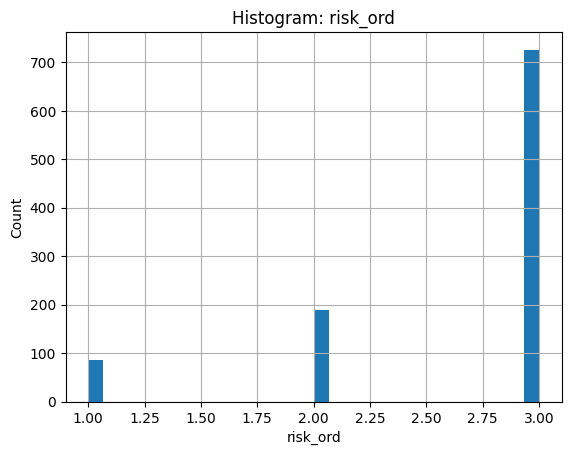

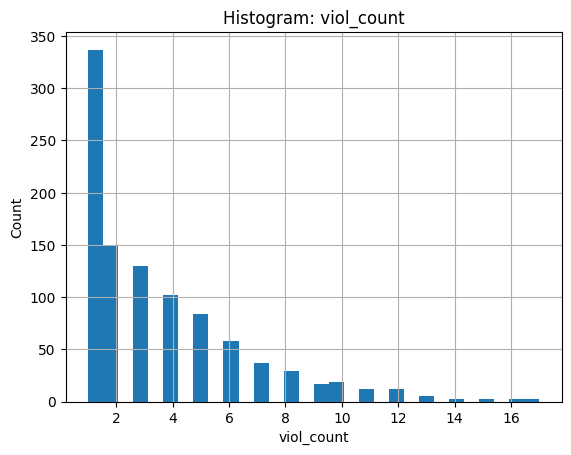

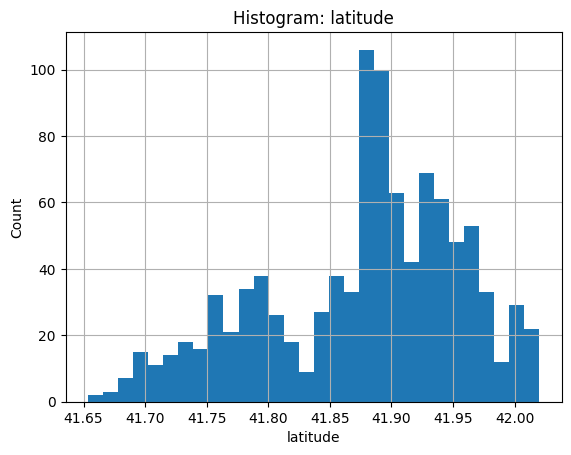

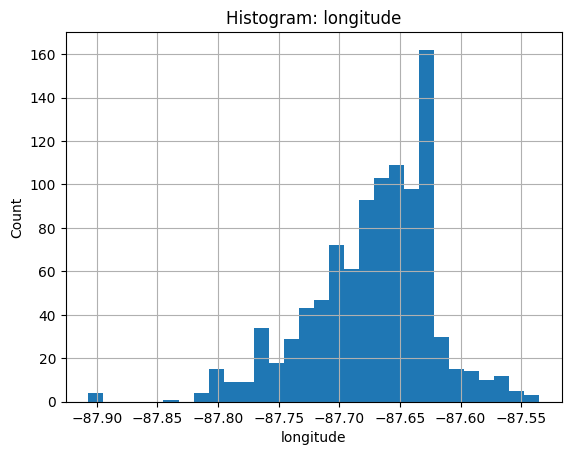

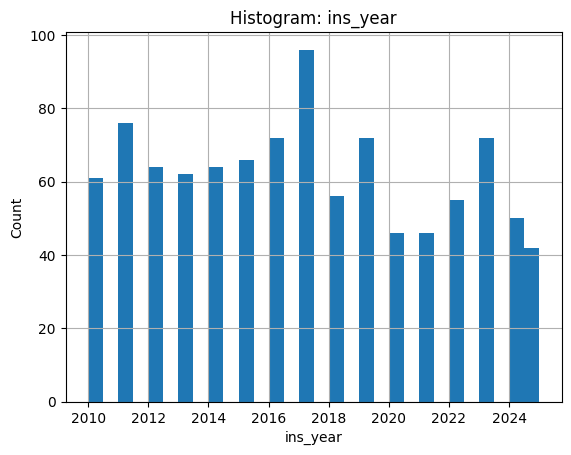

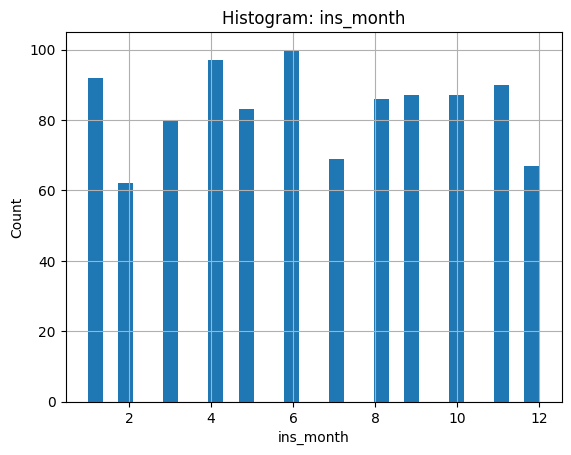

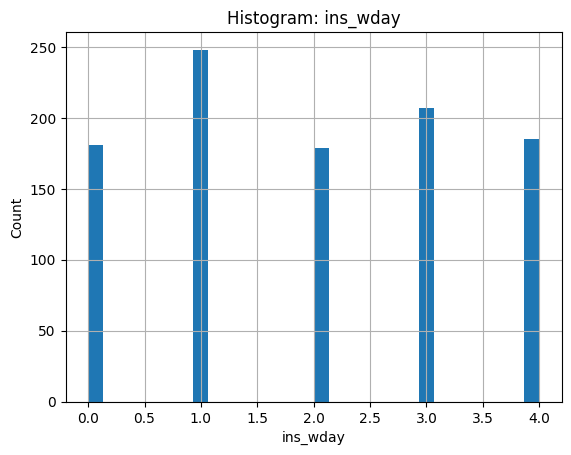

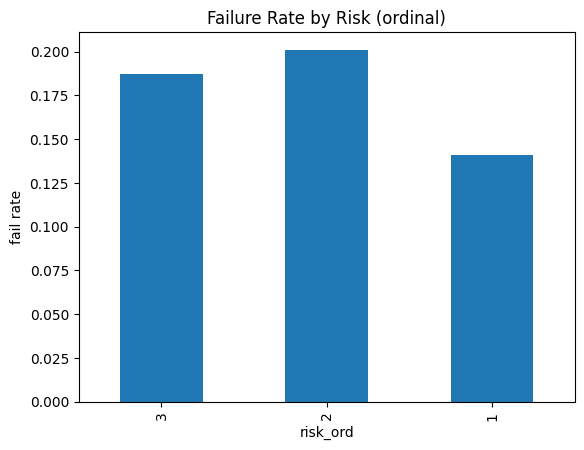

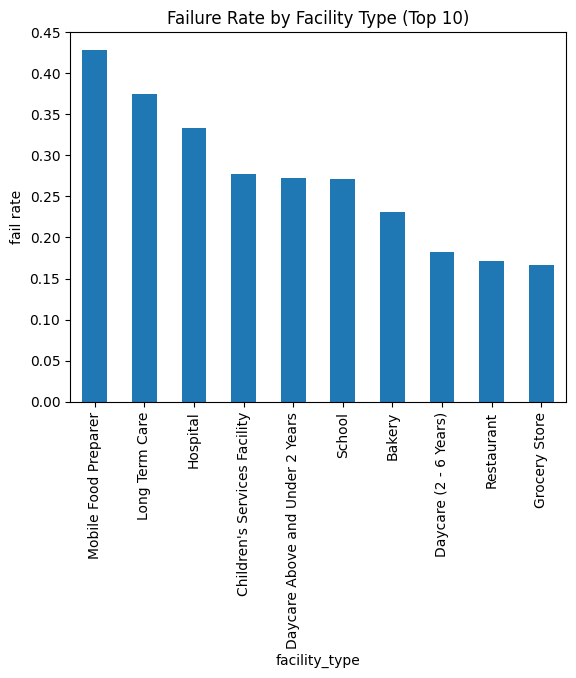

Saved plots (PNG) in current folder.


In [55]:
# EDA Plot

def save_hist(series: pd.Series, title:str, fname: str):
  plt.figure()
  series.dropna().hist(bins=30)
  plt.title(title); plt.xlabel(series.name); plt.ylabel("Count")
  plt.show()
  plt.savefig(fname, bbox_inches="tight"); plt.close()

# Numeric histograms
for col in ["risk_ord", "viol_count", "latitude", "longitude", "ins_year",
            "ins_month", "ins_wday"]:
    if col in train_clean.columns:
      save_hist(train_clean[col], f"Histogram: {col}", f"hist_{col}.png")

# Failure risk by rate
if {"risk_ord", "target_fail"}.issubset(train_clean.columns):
  tmp = train_clean[["risk_ord", "target_fail"]].dropna()
  risk_fail = tmp.groupby("risk_ord")["target_fail"].mean().sort_index(ascending=False)

  plt.figure()
  risk_fail.plot(kind="bar")
  plt.title("Failure Rate by Risk (ordinal)")
  plt.xlabel("risk_ord"); plt.ylabel("fail rate")
  plt.show()
  plt.savefig("bar_fail_rate_by_risk.png", bbox_inches="tight"); plt.close()
  plt.close()
# Failure rate by facility type
if {"facility_type", "target_fail"}.issubset(train_clean.columns):
  sub = train_clean[["facility_type", "target_fail"]].dropna()
  # Filter out 'nan' facility types
  sub = sub[sub["facility_type"] != 'nan']
  top_ft = sub["facility_type"].value_counts().head(10).index
  sub = sub[sub["facility_type"].isin(top_ft)]
  rate = sub.groupby("facility_type")["target_fail"].mean().sort_values(ascending=False)
  plt.figure()
  rate.plot(kind="bar")
  plt.title("Failure Rate by Facility Type (Top 10)")
  plt.xlabel("facility_type"); plt.ylabel("fail rate")
  plt.show()
print("Saved plots (PNG) in current folder.")

In [56]:
def validate_splits(train_df: pd.DataFrame, test_df: pd.DataFrame):
  ct, cv = set(train_df.columns), set(test_df.columns)
  if ct!= cv:
    print("column mismsatch")
    only_train = sorted(ct- cv)
    only_test = sorted(cv- ct)
    print(f"Only in train: {only_train}")
    print(f"Only in test: {only_test}")

  for c in sorted(ct & cv):
    if str(train_df[c].dtype) != str(test_df[c].dtype):
      print(f"Dtype mismatch in {c}: {train_df[c].dtype} != {test_df[c].dtype}")

  for c in ["risk", "facility_type", "results"]:
    if c in train_df.columns and c in test_df.columns and train_df[c].dtype == "object":
      unseen = set(test_df[c].dropna().unique()) - set(train_df[c].dropna().unique())
      if unseen:
            unseen_list = list(unseen)
            preview = unseen_list[:25]
            print(f"Unseen values in {c}: {unseen}")

validate_splits(train_clean, test_clean)

Unseen values in risk: {'nan'}
Unseen values in facility_type: {'OUTREACH CULINARY KITCHEN', 'STORE', 'CHARTER SCHOOL', 'MOBILE FROZEN DESSERTS DISPENSER-NON-MOTORIZED', 'ROOFTOP', 'Shared Kitchen User (Long Term)', 'DOLLAR STORE', 'MEXICAN CANDY STORE', 'HOT DOG STATION', 'Special Event', 'GAS STATION/STORE'}


In [57]:
# save artifacts
train_clean.to_csv("train_clean.csv", index= False)
test_clean.to_csv("test_clean.csv", index= False)

meta = {}
for c in train_clean.columns:
  if train_clean[c].dtype == "object":
    meta[c] = {"dtype": "object", "top_values": train_clean[c].value_counts().head(20).index.tolist()}
  else:
    meta[c] = {"dtype": str(train_clean[c].dtype)}
with open ("meta_schema.json", "w", encoding="utf-8") as f:
  json.dump(meta, f, indent=2)
print("Saved: meta_schema.json, test_clean.csv, meta_schema.json")

Saved: meta_schema.json, test_clean.csv, meta_schema.json


In [58]:
train_clean.isna().mean().sort_values(ascending=False).to_csv("missin")

In [59]:
# Load train +test CSVs

train = pd.read_csv("/content/training_sample1000.csv")
test = pd.read_csv("/content/testing_sample1000.csv")

col_drop=["target_fail", "violations", "results"]
X_train = train.drop(columns=col_drop)
y_train = train["target_fail"]

X_test = test.drop(columns=col_drop)
y_test = test["target_fail"]

print(X_train.columns)


Index(['inspection_id', 'inspection_date', 'facility_type', 'risk',
       'inspection_type', 'zip', 'city', 'latitude', 'longitude',
       'viol_count'],
      dtype='object')


In [60]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import (roc_auc_score, average_precision_score,
                             precision_recall_fscore_support,
                             roc_curve,
                             precision_recall_curve,
                             confusion_matrix,
                             ConfusionMatrixDisplay)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import matplotlib.pyplot as plt

# Identify feature types
numeric_features = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X_train.select_dtypes(include=["object", "bool", "category"]).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ],
    remainder = "passthrough"
)

# Define models
models = {
    "log_reg": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "tree": DecisionTreeClassifier(class_weight="balanced", random_state=0),
    "rf": RandomForestClassifier(n_estimators= 200, class_weight="balanced", random_state=0),
    "gb": GradientBoostingClassifier(random_state=0)
}

pipeline = {
    name: Pipeline(steps=[("preprocess", preprocessor), ("clf", model)])
    for name, model in models.items()
}

In [61]:
# Stratified 5-fold CV with multiple metrics
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

cv_results = []

for name,pipe in pipeline.items():
  scores = cross_validate(
      pipe,
      X_train,
      y_train,
      cv=cv,
      scoring = {
          "roc_auc": "roc_auc",
          "pr_auc": "average_precision",
          "precision": "precision",
          "recall": "recall",
          "f1": "f1",
      },
      return_train_score = False,
  )
  cv_results.append({
      "model": name,
      "roc_auc": scores["test_roc_auc"].mean(),
      "pr_auc": scores["test_pr_auc"].mean(),
      "precision": scores["test_precision"].mean(),
      "recall": scores["test_recall"].mean(),
      "f1": scores["test_f1"].mean(),
  })

  cv_df = pd.DataFrame(cv_results)
  cv_df.sort_values("roc_auc", ascending=False)

  from sklearn.model_selection import GridSearchCV

  # Hyperparameter grid for Log Reg
  param_grid = {
      "clf__C": [0.01, 0.1, 1, 10],
      "clf__penalty": ["l2"],
      "clf__solver": ["lbfgs"]
  }

  logreg_pipe = Pipeline(steps=[
      ("preprocess", preprocessor),
      ("clf", LogisticRegression(max_iter=1000, class_weight="balanced"))
  ])

  grid = GridSearchCV(estimator = logreg_pipe, param_grid=param_grid, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=0), scoring="roc_auc", n_jobs=-1)
  grid.fit(X_train, y_train)

  print("Best Hyperparameters:", grid.best_params_)
  print("Best CV ROC-AUC:", grid.best_score_)

Best Hyperparameters: {'clf__C': 1, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
Best CV ROC-AUC: 0.8242209166436915
Best Hyperparameters: {'clf__C': 1, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
Best CV ROC-AUC: 0.8242209166436915
Best Hyperparameters: {'clf__C': 1, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
Best CV ROC-AUC: 0.8242209166436915
Best Hyperparameters: {'clf__C': 1, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
Best CV ROC-AUC: 0.8242209166436915


In [62]:
cv_df.sort_values("roc_auc", ascending=False)

,model,roc_auc,pr_auc,precision,recall,f1
0,log_reg,0.824221,0.582174,0.402428,0.650640,0.496572
3,gb,0.801534,0.513808,0.656720,0.269275,0.380085
2,rf,0.792480,0.487344,0.724286,0.075533,0.134240
1,tree,0.625819,0.272591,0.381806,0.403983,0.391360


In [63]:
# Pick best model by ROC-AUC
best_name = cv_df.sort_values("roc_auc", ascending=False).iloc[0]["model"]
best_pipe = grid.best_estimator_
best_pipe.fit(X_train, y_train)

# Test set eval
y_proba = best_pipe.predict_proba(X_test)[:, 1]
y_pred = best_pipe.predict(X_test)

test_roc = roc_auc_score(y_test, y_proba)
test_pr = average_precision_score(y_test, y_proba)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary")

print(f"Best model: {best_name}")
print(f"Test ROC-AUC: {test_roc:.3f}")
print(f"Test PR-AUC: {test_pr:.3f}")
print(f"Test Precision: {prec:.3f}")
print(f"Test Recall: {rec:.3f}")
print(f"Test F1: {f1:.3f}")

Best model: log_reg
Test ROC-AUC: 0.811
Test PR-AUC: 0.548
Test Precision: 0.429
Test Recall: 0.691
Test F1: 0.530


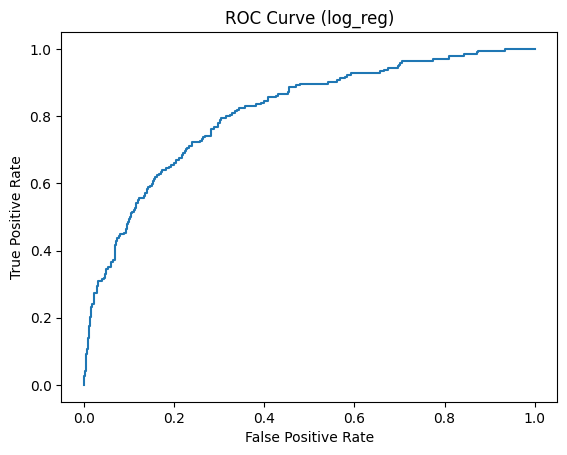

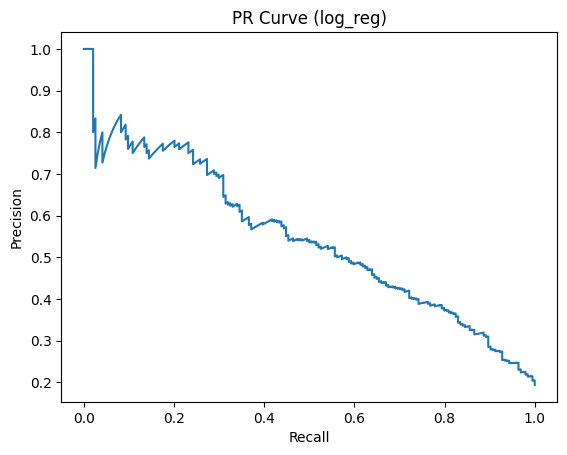

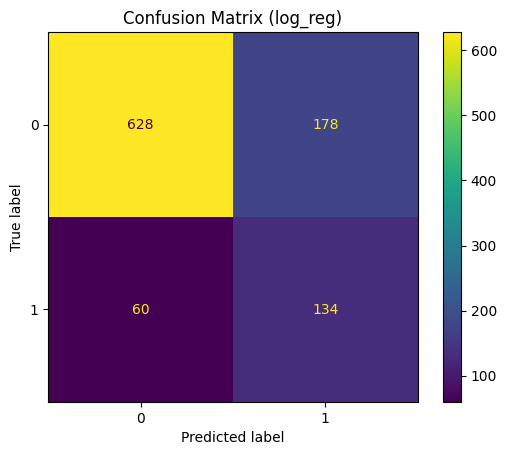

In [64]:
# ROC + PR Curves
fpr, tpr, _ = roc_curve(y_test, y_proba)
prec_curve, rec_curve, _ = precision_recall_curve(y_test, y_proba)

plt.figure()
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve ({best_name})")
plt.show()


plt.figure()
plt.plot(rec_curve, prec_curve)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"PR Curve ({best_name})")
plt.show()

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title(f"Confusion Matrix ({best_name})")
plt.show()